In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
from bicycle import *

In [3]:
import sys 
sys.path.append('..')
from codeprint import RawCode

## Bicycle Model

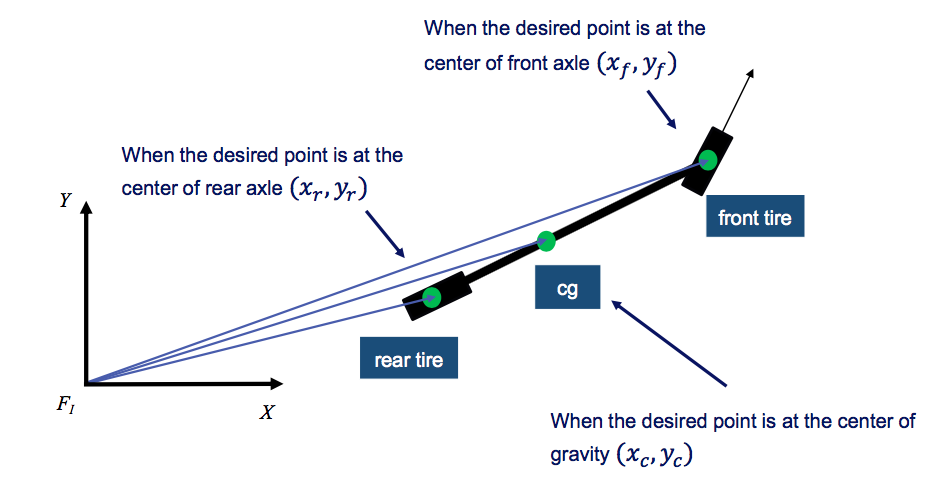

In [4]:
Image('bicycle_model.png', width=500)

In [5]:
code = RawCode('bicycle.py')
code.show('BicycleModel')

class BicycleModel():
    def __init__(self, L, dt, model_type):
        self.L = L
        self.dt = dt
        self.model_type = model_type 

    def model(self, *args):
        if self.model_type == 'rear':
            return self.bicycle_rear_axle(*args)
        if self.model_type == 'front':
            return self.bicycle_front_axle(*args)

    def bicycle_rear_axle(self, state, v, gamma):
        #state : x, y, theta
        x, y, theta = state
        delta = np.array([v*np.cos(theta), v*np.sin(theta), v/self.L*np.tan(gamma)])
        next_state = state + delta  * self.dt
        return next_state
    
    def bicycle_front_axle(self, state, v, gamma):
        #state : x, y, theta
        x, y, theta = state
        delta = np.array([v*np.cos(theta+gamma), 
                          v*np.sin(theta+gamma), 
                          v/self.L*np.sin(gamma)])
        next_state = state + delta  * self.dt
        return next_state

    def set_state(self, state, gamma=0):
        s

### Transformation Class : Transformation for Visualization

In [6]:
code.show('Transformation')

class Transformation():
    # Transformation for drawing two wheels
    def convert_se2(self, p, theta):
        p = np.array(p)[:,None]
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c,-s],[s,c]])
        return np.block([[R, p],[np.zeros((1,2)), 1]])

    def invert_se2(self, T):
        theta = np.arctan2(T[1,0], T[0,0])
        p = T[:2, -1]
        return p, theta


### Bicycle Class : Transformation + BicycleModel + Visualization

In [7]:
code.show('Bicycle')

class Bicycle(Transformation, BicycleModel):
    wheel_len = 1
    wheel_width = 0.5
    arrow_len = 1
    view = [-10, 10, -10, 10]

    def show(self):
        self.draw_wheels()
        self.draw_arrow()
        plt.axis(self.view)
        plt.grid()
    
    def update(self):
        ax = plt.gca()
        xy, theta = self.calc_wheel_pos(wheel_type='main')
        self.main_wheel.set_xy(xy)
        self.main_wheel.angle = np.rad2deg(theta)
        xy, theta = self.calc_wheel_pos(wheel_type='sub')
        self.sub_wheel.set_xy(xy)
        self.sub_wheel.angle = np.rad2deg(theta)
        self.arrow.set_visible(False)
        self.arrow.remove()
        self.draw_arrow()

    def calc_wheel_pos(self, wheel_type='main'):
        T_s_wheel = self.convert_se2(self.state[:2], self.state[2])
        if wheel_type=='sub':
            if self.model_type == 'rear':
                T_main_sub = self.convert_se2([self.L,0], 0)
            if self.model_type == 'front':
                T_main_su

### Visualization 

### Rear-Axle Bicycle Model

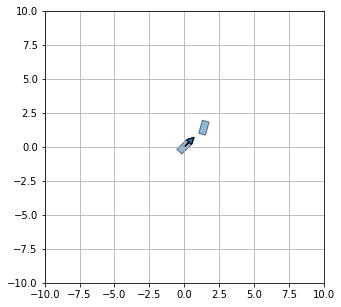

In [8]:
bicycle_rear = Bicycle(L=2, dt=0.1, model_type='rear')
state = [0,0,np.pi/4]
gamma = np.pi/6
fig, ax = plt.subplots(figsize=[5,5])
bicycle_rear.set_state(state,gamma)
bicycle_rear.show()

### Front-Axle Bicycle Model 

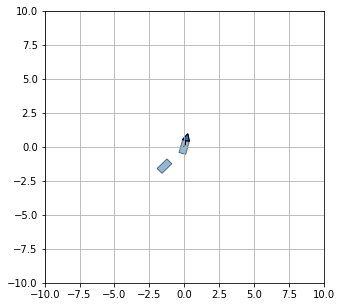

In [9]:
bicycle_front = Bicycle(L=2, dt=0.1, model_type='front')
state = [0,0,np.pi/4]
gamma = np.pi/6
fig, ax = plt.subplots(figsize=[5,5])
bicycle_front.set_state(state,gamma)
bicycle_front.show()

### Simple Open-loop simulation 

In [10]:
#bicycle = bicycle_front
bicycle = bicycle_rear

In [11]:
start = [0,0,0]
# fixed velocity, steering
v = 1
gamma = 0.5

In [12]:
states = ['x','y','theta']
sim = pd.DataFrame(columns=['time']+states)
sim['time'] = np.arange(0, 10, 0.1)
sim.loc[0,states] = start

In [13]:
curr_state = sim.loc[0,states]
for i, row in sim.iterrows():
    next_state = bicycle.model(curr_state, v, gamma)
        
    if i < len(sim)-1:
        sim.loc[i+1,states] = next_state
        sim.loc[i+1, 'v'] = v
        sim.loc[i+1, 'gamma'] = gamma
    
    curr_state = next_state
sim

,time,x,y,theta,v,gamma
0,0.0,0,0,0,NaN,NaN
1,0.1,0.1,0,0.0273151,1.0,0.5
2,0.2,0.199963,0.00273117,0.0546302,1.0,0.5
3,0.3,0.299814,0.00819148,0.0819454,1.0,0.5
4,0.4,0.399478,0.0163769,0.10926,1.0,0.5
...,...,...,...,...,...,...
95,9.5,1.99569,6.76201,2.59494,1.0,0.5
96,9.6,1.91027,6.814,2.62225,1.0,0.5
97,9.7,1.82345,6.86363,2.64957,1.0,0.5
98,9.8,1.73531,6.91087,2.67688,1.0,0.5


### Result 

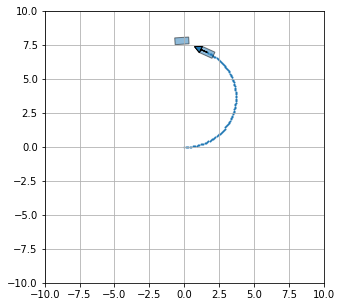

In [14]:
fig, ax = plt.subplots(figsize=[5,5])
state = sim.loc[len(sim)-1, ['x','y','theta']].tolist()
gamma = sim.loc[len(sim)-1, ['gamma']][0]
bicycle.set_state(state, gamma)
bicycle.show();
plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1);

### draw animation 

In [38]:
from animake import AniMaker
anim = AniMaker()

In [39]:
fig, ax = plt.subplots(figsize=[5,5])
state = sim.loc[0,['x','y','theta']].tolist()
bicycle.set_state(state,0)
bicycle.show()

for i, row in sim.iterrows():
    state = row.loc[['x','y','theta']].to_numpy()
    gamma = row.loc['gamma']
    bicycle.set_state(state, gamma)
    bicycle.update();
    path = plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1, color='k')
    anim.set_snapshot()
    path.remove()
    
plt.close()

image added:  100


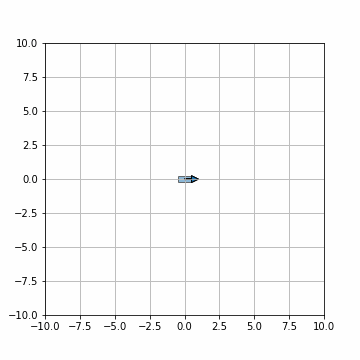

In [40]:
anim.make_gif('out_bicycle_rear.gif')
Image(filename="out_bicycle_rear.gif")